In [1]:
# needed to import dataset from google drive into colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
!ls

gdrive	sample_data


In [3]:
# copy  dataset from gdrive and unzip
!cp '/content/gdrive/My Drive/skin.zip' .

In [5]:
!unzip -q skin.zip

In [9]:
# Import all the Dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.applications import ResNet50

In [10]:
# Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 100

In [11]:
!ls

gdrive	sample_data  skin  skin.zip


In [12]:
# Import dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "skin",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
class_names

Found 3297 files belonging to 2 classes.


['benign', 'malignant']

In [13]:
# Function to Split Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
# Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
# Building the Model
# Creating a new Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./244),
])

In [17]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [19]:

# Model Architecture
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(n_classes, activation='softmax')
])

model.build((None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [21]:
# Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/100
83/83 [==============================] - 99s 424ms/step - loss: 0.6064 - accuracy: 0.7432 - val_loss: 0.8118 - val_accuracy: 0.5063
Epoch 2/100
83/83 [==============================] - 31s 369ms/step - loss: 0.4836 - accuracy: 0.7798 - val_loss: 0.6932 - val_accuracy: 0.5063
Epoch 3/100
83/83 [==============================] - 30s 354ms/step - loss: 0.4307 - accuracy: 0.7810 - val_loss: 0.6884 - val_accuracy: 0.5312
Epoch 4/100
83/83 [==============================] - 30s 355ms/step - loss: 0.3859 - accuracy: 0.8091 - val_loss: 0.6925 - val_accuracy: 0.5063
Epoch 5/100
83/83 [==============================] - 30s 354ms/step - loss: 0.3682 - accuracy: 0.8217 - val_loss: 0.6831 - val_accuracy: 0.7375
Epoch 6/100
83/83 [==============================] - 30s 356ms/step - loss: 0.3373 - accuracy: 0.8411 - val_loss: 0.6808 - val_accuracy: 0.4938
Epoch 7/100
83/83 [==============================] - 29s 349ms/step - loss: 0.3556 - accuracy: 0.8373 - val_loss: 0.6919 - val_accuracy:

In [23]:
# Saving the Model
model.save("skinResNet.h5")

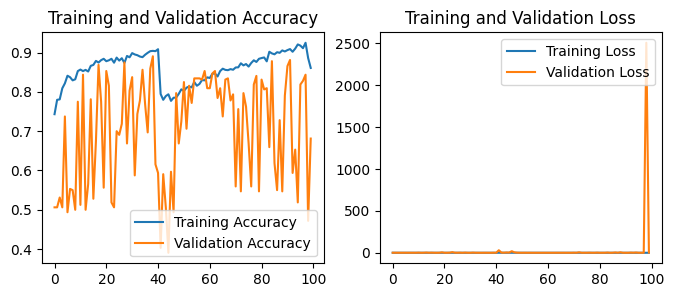

In [24]:
# Plotting the Accuracy and Loss Curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 83}

1/1 [==============================] - 0s 25ms/step


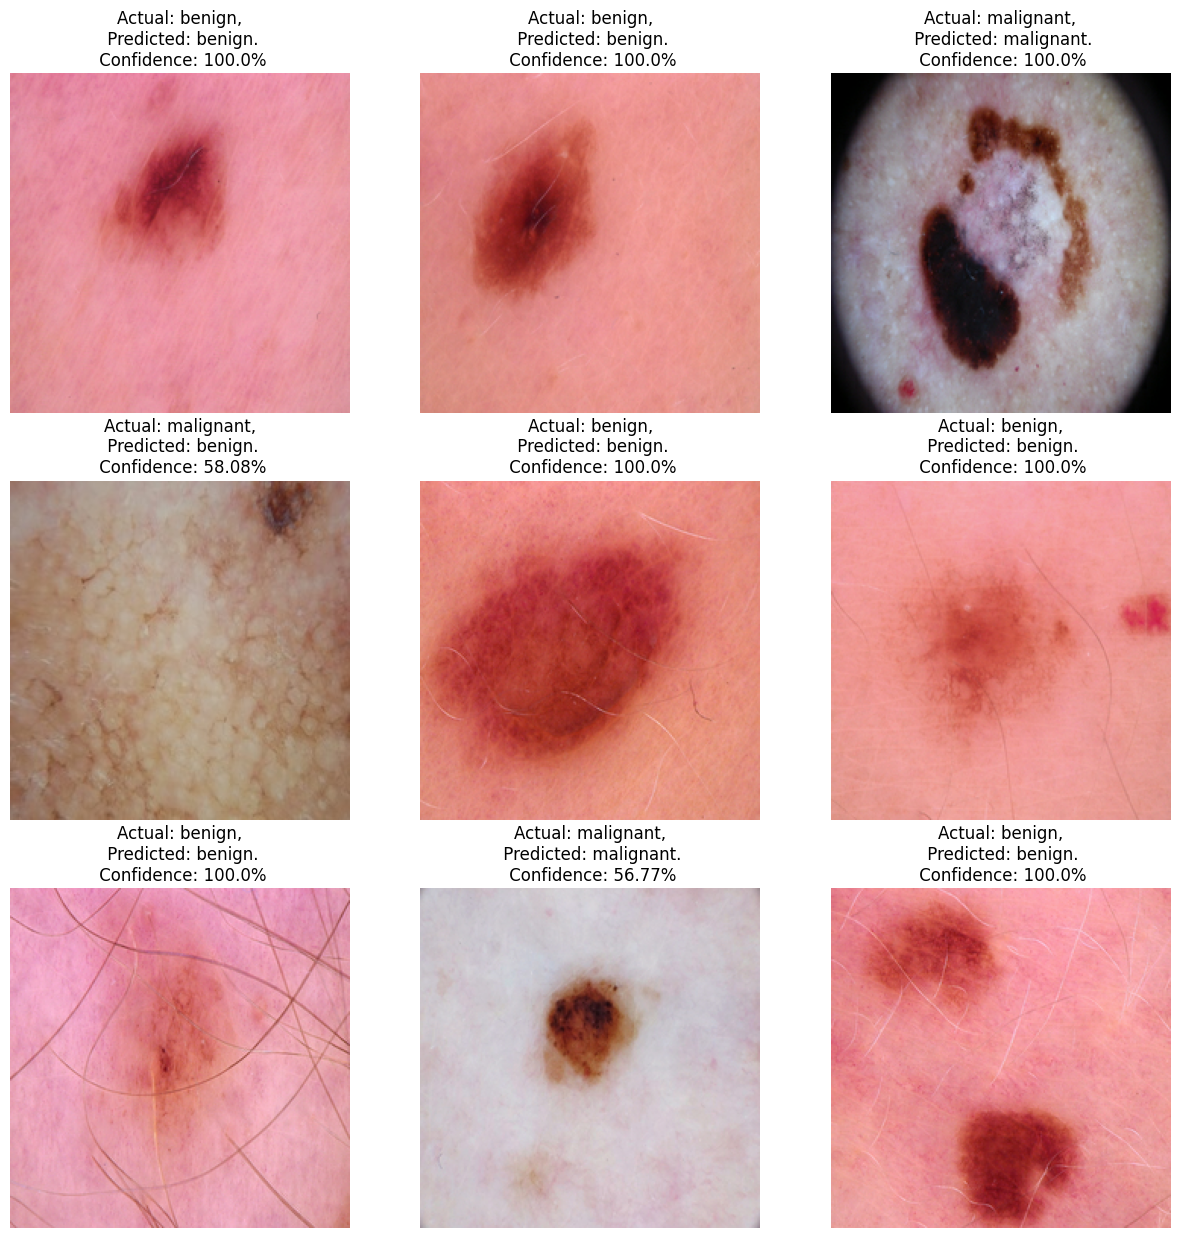

In [26]:
# Run prediction on a sample image
def predict(model, img):
    img_array = tf.expand_dims(img, 0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [28]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


11/11 [==============================] - 1s 99ms/step - loss: 2.8602 - accuracy: 0.6875
Test Loss: 2.8602144718170166
Test Accuracy: 0.6875


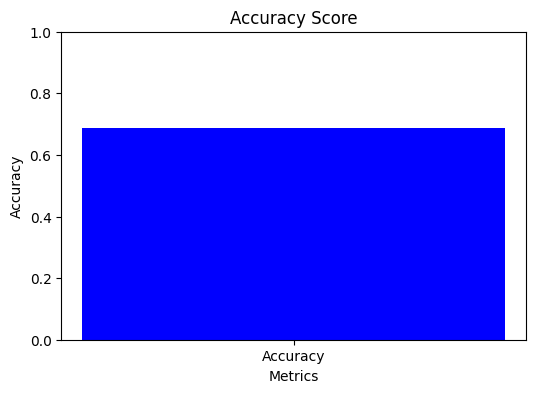

In [33]:

# Plotting the Accuracy Score
plt.figure(figsize=(6, 4))
plt.bar(["Accuracy"], [scores[1]], color='blue')
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.xlabel("Metrics")
plt.ylabel("Accuracy")
plt.title("Accuracy Score")
plt.show()


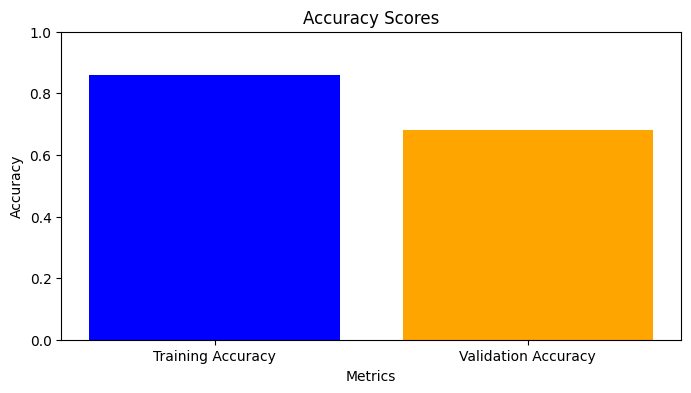

In [29]:
# Plotting the Training Accuracy Score and Validation Accuracy Score
plt.figure(figsize=(8, 4))
metrics = ["Training Accuracy", "Validation Accuracy"]
accuracy_scores = [acc[-1], val_acc[-1]]

plt.bar(metrics, accuracy_scores, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.xlabel("Metrics")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores")
plt.show()


1/1 [==============================] - 0s 33ms/step


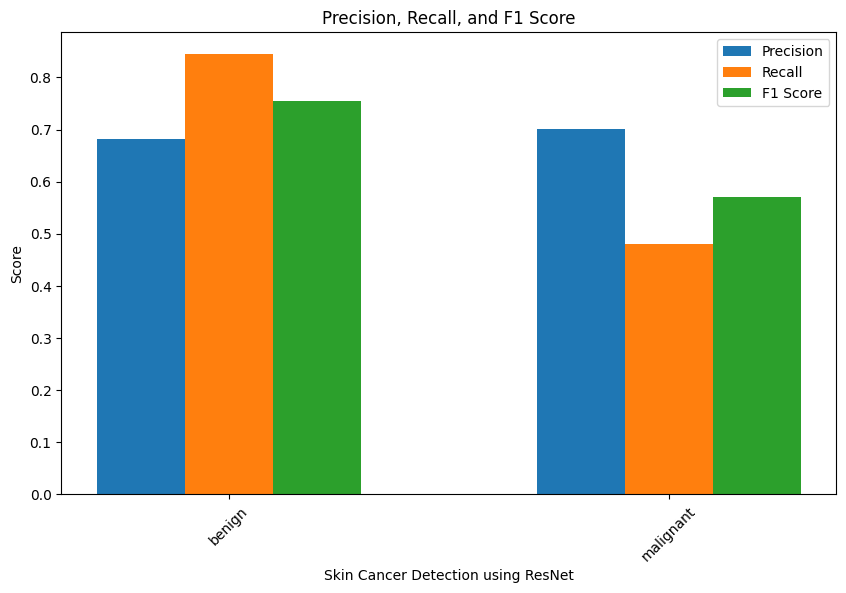

In [34]:

# Printing Precision, Recall, and F1 Score
test_images = []
test_labels = []
predicted_labels = []

for images_batch, labels_batch in test_ds:
    test_images.extend(images_batch.numpy())
    test_labels.extend(labels_batch.numpy())
    batch_prediction = model.predict(images_batch)
    predicted_labels.extend(np.argmax(batch_prediction, axis=1))

test_labels = np.array(test_labels)
predicted_labels = np.array(predicted_labels)

precision = precision_score(test_labels, predicted_labels, average=None)
recall = recall_score(test_labels, predicted_labels, average=None)
f1 = f1_score(test_labels, predicted_labels, average=None)

# Plotting the metrics
plt.figure(figsize=(10, 6))
x = np.arange(len(class_names))

plt.bar(x - 0.2, precision, width=0.2, label='Precision')
plt.bar(x, recall, width=0.2, label='Recall')
plt.bar(x + 0.2, f1, width=0.2, label='F1 Score')

plt.xticks(x, class_names, rotation=45)
plt.xlabel('Skin Cancer Detection using ResNet')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score')
plt.legend()
plt.show()


1/1 [==============================] - 0s 35ms/step


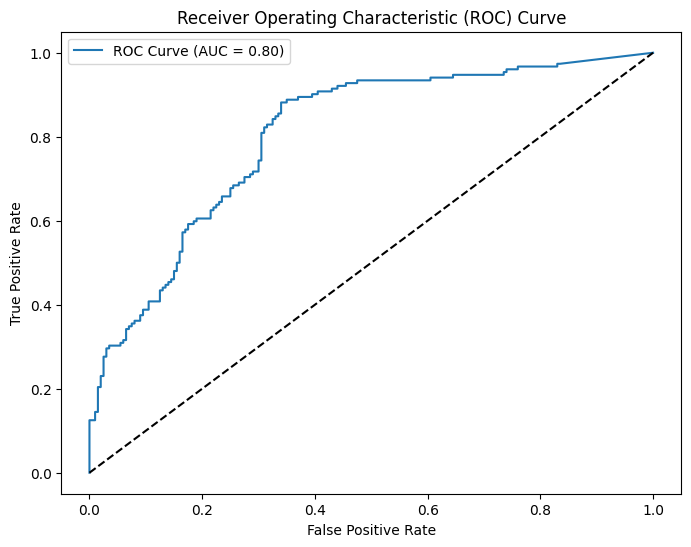

AUC Score: 0.803717105263158


In [32]:
# After evaluating the model on the test set
test_labels = []
predicted_probabilities = []

for images_batch, labels_batch in test_ds:
    test_labels.extend(labels_batch.numpy())
    batch_prediction = model.predict(images_batch)
    predicted_probabilities.extend(batch_prediction)

test_labels = np.array(test_labels)
predicted_probabilities = np.array(predicted_probabilities)

# Calculate the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(test_labels, predicted_probabilities[:, 1])
auc_score = roc_auc_score(test_labels, predicted_probabilities[:, 1])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print the AUC score
print('AUC Score:', auc_score)
